In [1]:
num_dz = 500 #input("How many diseases to sample? ") 
num_articles = 50 #input("How many abstracts to gather per disease? ")
test_num = 3 #input("How many articles to retrieve in test set? 2-5 is recommended. ")

In [2]:
#Download any necessary datasets & dependencies, only need to do this once
#import sys
#!{sys.executable} -m pip install spacy
#!{sys.executable} -m spacy download en_core_web_lg
#!{sys.executable} -m pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bc5cdr_md-0.4.0.tar.gz
#!{sys.executable} -m pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bionlp13cg_md-0.4.0.tar.gz
#!{sys.executable} -m pip install numpy
#!{sys.executable} -m pip install pandas
#!{sys.executable} -m pip install requests
#!{sys.executable} -m pip install matplotlib

#Installing dependencies for classify_abs.py
#!{sys.executable} -m pip install tensorflow
#!{sys.executable} -m pip install nltk
#import nltk
#nltk.download('stopwords')
#nltk.download('punkt')

import numpy as np
import pandas as pd
import classify_abs
import requests
import xml.etree.ElementTree as ET
import spacy
import time
import datetime
from collections import OrderedDict
import matplotlib.pyplot as plt; plt.rcdefaults()

2021-07-03 00:16:22.821825: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-03 00:16:22.821866: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
#Read in GARD diseases
df = pd.read_csv('GARD.csv')
df.tail()

,d.gard_id,d.name,d.synonyms
6056,GARD:0013731,T-cell prolymphocytic leukemia,[T Cell Prolymphocytic Leukemia]
6057,GARD:0013735,Spastic paraplegia 47,NaN
6058,GARD:0013737,AP-4-Associated Hereditary Spastic Paraplegia,[Severe intellectual disability and progressiv...
6059,GARD:0013743,"Multicentric osteolysis, nodulosis and arthrop...","[Torg-Winchester Syndrome,Torg Syndrome,Nodulo..."
6060,GARD:0013818,Sphingosine phosphate lyase insufficiency synd...,"[SPL insufficiency syndrome,SPLIS,Familial ste..."


In [4]:
#GARD.csv d.synonyms has oddly saved string data that cannot be converted directly into a list, this converts that
def str2list(string):
    string = str(string).replace('[','')
    string = string.replace(']','')
    string = string.strip()
    str_list = string.split(',')
    for s in str_list:
        s = s.strip()
        if s=='nan':
            str_list.remove('nan')
    return str_list

In [5]:
#Convert d.synonym strings into lists
i=0
for i in range(len(df['d.synonyms'])):
    df['d.synonyms'][i] = str2list(df['d.synonyms'][i])

In [6]:
#Set up a new & easier to use df, with just id and list of names
df_names = pd.DataFrame(df['d.gard_id'],columns=['d.gard_id','d.names'])

rowlist = []
i=0
for i in range(len(df)):
    columnlist=[]
    columnlist.append(df['d.name'][i])
    columnlist+=df['d.synonyms'][i]
    rowlist.append(columnlist)
df_names['d.names'] = rowlist

In [7]:
df_names.tail()

,d.gard_id,d.names
6056,GARD:0013731,"[T-cell prolymphocytic leukemia, T Cell Prolym..."
6057,GARD:0013735,[Spastic paraplegia 47]
6058,GARD:0013737,[AP-4-Associated Hereditary Spastic Paraplegia...
6059,GARD:0013743,"[Multicentric osteolysis, nodulosis and arthro..."
6060,GARD:0013818,[Sphingosine phosphate lyase insufficiency syn...


In [8]:
#Randomly pick n disease names
dz_list = df_names['d.names'].sample(n=num_dz).values.tolist()
print(dz_list)

[['Syngnathia cleft palate'], ['ROHHAD', 'Rapid-onset obesity with hypothalamic dysfunction', ' hypoventilation and autonomic dysregulation'], ['Infantile digital fibromatosis', 'IDF', 'Asymptomatic nodular proliferation of fibrous tissue on the dorsal and lateral aspects of the fingers or toes'], ['Spastic tetraplegia-thin corpus callosum-progressive postnatal microcephaly syndrome', 'ASCT1 deficiency', 'Spastic quadriplegia-thin corpus callosum-progressive postnatal microcephaly syndrome', 'Spastic tetraplegia', ' thin corpus callosum', ' and progressive microcephaly', 'SPATCCM'], ['Cardiac rupture'], ['Megalocytic interstitial nephritis', 'Interstitial megalocytic nephritis', 'Transplant megalocytic interstitial nephritis (type)'], ['Adenylosuccinase deficiency', 'Adenylosuccinate lyase deficiency', 'ADSL deficiency'], ['Say syndrome', 'Cleft palate large ears small head', 'Cleft palate', ' microcephaly', ' large ears', ' and short stature', 'Say Barber Hobbs syndrome'], ['Spinal mu

In [9]:
def get_pmids_abstract(dz_name, maxResults):
    # get results from searching for disease name through EBI API
    term = ''
    dz_words = dz_name.split()
    for word in dz_words:
        term += word + '%20'
    query = term[:-3]
    url = 'https://www.ebi.ac.uk/europepmc/webservices/rest/search?query='+query+'&resulttype=core'
    r = requests.get(url)
    root = ET.fromstring(r.content)

    pmid_abs = {}
    i = 0
    # loop over resulting articles
    for result in root.iter('result'):
        if i >= maxResults:
            break
        pmids = [pmid.text for pmid in result.iter('id')]
        if len(pmids) > 0:
            pmid = pmids[0]
            if pmid[0].isdigit():
                abstracts = [abstract.text for abstract in result.iter('abstractText')]
                if len(abstracts) > 0:
                    pmid_abs[pmid] = abstracts[0]
                    i += 1
    return pmid_abs, i

In [10]:
#Test get_pmids_abstract (and epiPredictions) function and generates estimated time of completion
dz_num_articles={}
dz_pmid_abs_list =[]
t1 = time.time()
for namelist in dz_list[0:2]:
    i =0
    for name in namelist:
        #pmids_abs ={}
        pmid_abs, abs_returned = get_pmids_abstract(name, test_num)
        i+=abs_returned
        dz_pmid_abs_list.append(pmid_abs)
        if i>=test_num:
            break 
    dz_num_articles[namelist[0]] = i
t2 = time.time()
avg_time = (t2-t1)/test_num
print('Test completed in ',t2-t1,'seconds')
print('Average seconds per PubMed Id & Abstracts call: '+ str(avg_time))
print('Est. time to build dataset of '+str(num_dz*num_articles)+' abstracts: ' + str(datetime.timedelta(seconds=(avg_time*num_dz*num_articles))))
print('Est. completion is:',time.ctime(time.time()+avg_time*num_dz*num_articles))

Test completed in  2.427844762802124 seconds
Average seconds per PubMed Id & Abstracts call: 0.809281587600708
Est. time to build dataset of 25000 abstracts: 5:37:12.039690
Est. completion is: Sat Jul  3 05:53:39 2021


In [11]:
#Actually get all of the Pubmed IDs and Articles
dz_num_articles = {}
dz_pmid_abs_list = []

t1 = time.time()
for namelist in dz_list:
    i = 0
    for name in namelist:
        pmid_abs, abs_returned = get_pmids_abstract(name, num_articles)
        i+=abs_returned
        dz_pmid_abs_list.append(pmid_abs)
        if i>=num_articles:
            break 
    dz_num_articles[namelist[0]] = i
t2 = time.time()
print('It took '+ str(datetime.timedelta(seconds=(t2-t1)))+' to build dataset of '+str(num_dz*num_articles)+' abstracts.')
print('Completion time is:',time.ctime(t2))

It took 0:22:24.522713 to build dataset of 25000 abstracts.
Completion time is: Sat Jul  3 00:38:51 2021


In [12]:
#print(dz_num_articles)
#print('----------------------')
#Sort the dictionary
dz_num_articles = dict(sorted(dz_num_articles.items(), key=lambda x: x[1]))
#print(dz_num_articles)

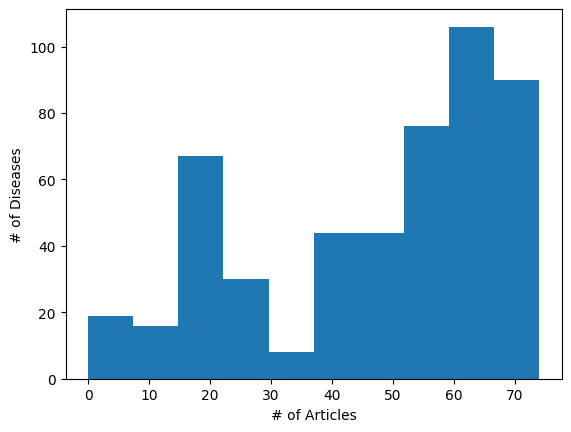

In [13]:
#Plot the histogram
objects = tuple(dz_num_articles)
performance = list(dz_num_articles.values())
#y_pos = np.arange(performance)

fig = plt.figure()
plt.ylabel('# of Diseases')
plt.xlabel('# of Articles')
plt.hist(performance)

plt.show()

In [14]:
fig.savefig('ArticlesPerDisease_Hist.png', dpi=400, bbox_inches='tight')

This is the section for gathering predictions
--------------------------------------------------------------

In [15]:
#Load spacy models for epi predictions
nlp = spacy.load('en_core_web_lg')
nlpSci = spacy.load("en_ner_bc5cdr_md")
nlpSci2 = spacy.load('en_ner_bionlp13cg_md')

def epiPredictions(abstract, nlp, nlpSci, nlpSci2):
    # predict on each abstract
    prob, isEpi = classify_abs.getAbstractPredictions(abstract, nlp, nlpSci, nlpSci2, 'my_model_orphanet_final')
    return prob, isEpi 

In [16]:
#How to extract and piece together the df
print(dz_list[1][0])
print(dz_pmid_abs_list[1])

ROHHAD
{'32925400': 'Rapid onset Obesity, Hypothalamic dysfunction, Hypoventilation, and Autonomic Dysregulation (ROHHAD) is a rare syndrome whose underlying pathophysiology and etiology remain elusive. We present the case of a 36-month-old boy with the classic symptoms of ROHHAD and a neuroendocrine tumor, who progressed rapidly and subsequently succumbed to cardiorespiratory arrest because of hypoventilation. His magnetic resonance imaging findings at the initial diagnosis and the brain autopsy results are detailed. The literature was reviewed to summarize the current understanding of the underlying mechanism of this rare disorder.', '33542648': 'Rapid-onset obesity with hypoventilation, hypothalamic dysfunction, autonomic dysregulation (ROHHAD) syndrome is a rare disease with unknown and debated etiology, characterized by precipitous obesity in young children, hypoventilation and autonomic dysregulation with various endocrine abnormalities. Neuroendocrine tumors can be associated in

In [17]:
#Assemble dataset and run epiPredictions
df_results = pd.DataFrame(columns=['disease','pmid', 'abstract','epi_prob','is_epi'])
i=0
j=0
for namelist in dz_list:
    disease = namelist[0]
    for k, v in dz_pmid_abs_list[j].items():
        pmid = k
        abstract = v
        prob, is_epi = epiPredictions(abstract, nlp, nlpSci, nlpSci2)
        df_results.loc[i] = [disease]+[pmid]+[abstract]+[prob]+[is_epi]
        i+=1
    j+=1

2021-07-03 00:39:07.918560: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-07-03 00:39:07.918589: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-07-03 00:39:07.918604: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pubmed.ncats.io): /proc/driver/nvidia/version does not exist
2021-07-03 00:39:07.918779: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-03 00:39:15.337873: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of

In [18]:
df_results

,disease,pmid,abstract,epi_prob,is_epi
0,Syngnathia cleft palate,21501960,Syngnathia occurs when an ectopic membrane for...,0.012472,False
1,Syngnathia cleft palate,31378081,"In rare instances, cleft lip and palate occur ...",0.018302,False
2,Syngnathia cleft palate,31572079,Palatoglossal bands are one of the very rare c...,0.015344,False
3,Syngnathia cleft palate,32792827,Congenital pits on lower lips unassociated wit...,0.105112,False
4,Syngnathia cleft palate,30607232,The Van der Woude syndrome is a rare autosomal...,0.027180,False
...,...,...,...,...,...
9279,Cogan-Reese syndrome,33300272,Various methods have been described to treat n...,0.010466,False
9280,Cogan-Reese syndrome,33530790,<h4>Objective</h4>To assess the therapeutic ef...,0.014457,False
9281,Cogan-Reese syndrome,33985356,Mayer-Rokitansky-Kuster-Hauser (MRKH) syndrome...,0.402330,False
9282,Cogan-Reese syndrome,33898257,Mayer-Rokitansky-Küster-Hauser (MRKH) syndrome...,0.012231,False


In [19]:
positive_sentence_set = df_results[df_results.epi_prob > 0.5].sort_values('epi_prob', ascending=False)
positive_sentence_set

,disease,pmid,abstract,epi_prob,is_epi
370,"Deafness, autosomal dominant nonsyndromic sens...",33962637,<h4>Background</h4>The incidence of hydrocepha...,0.998725,True
5200,Anencephaly and spina bifida X-linked,33962637,<h4>Background</h4>The incidence of hydrocepha...,0.998725,True
3473,"Methylmalonic aciduria, cblB type",33990817,<h4>Introduction</h4>Limited data are availabl...,0.998415,True
9062,Doyne honeycomb retinal dystrophy,33712046,Juvenile Idiopathic Arthritis is one of the mo...,0.998407,True
9009,Malonyl-CoA decarboxylase deficiency,33185984,<h4>Aim</h4>To investigate the point prevalenc...,0.998325,True
...,...,...,...,...,...
7767,CD4 deficiency,34128866,<h4>Abstract</h4>Previous studies have suggest...,0.519289,True
1350,Muscle eye brain disease,31344241,<h4>Background and objective</h4>To understand...,0.514754,True
4267,Enchondromatosis dwarfism deafness,32355641,Anticancer drug nephrotoxicity is an important...,0.512264,True
7311,Severe congenital neutropenia autosomal dominant,33554218,Coronavirus disease 2019 (COVID-19) is emergin...,0.511204,True


In [20]:
positive_sentence_set.to_csv('positive_abstract_set.csv',index=False)

In [21]:
df_results.to_csv('whole_abstract_set.csv',index=False)

How many diseases have less than 5 articles?

In [22]:
num_dz = len(df_names) #input("How many diseases to sample? ") 
num_articles = 5 #input("How many abstracts to gather per disease? ")

In [23]:
#Pick all disease names
all_dz_list = df_names['d.names'].values.tolist()

In [24]:
#Actually get all of the Pubmed IDs and Articles
dz_num = {}
dz_pmid_abs = []

print('Est. time to build dataset of '+str(num_dz*num_articles)+' abstracts: ' + str(datetime.timedelta(seconds=(avg_time*num_dz*num_articles))))

t1 = time.time()
for namelist in all_dz_list:
    i = 0
    for name in namelist:
        pmid_abs, abs_returned = get_pmids_abstract(name, num_articles)
        i+=abs_returned
        dz_pmid_abs.append(pmid_abs)
        if i>=num_articles:
            break 
    dz_num[namelist[0]] = i
t2 = time.time()
print('It took '+ str(datetime.timedelta(seconds=(t2-t1)))+' to build dataset of '+str(num_dz*num_articles)+' abstracts.')
print('Completion time is:',time.ctime(t2)

SyntaxError: unexpected EOF while parsing (2064042819.py, line 19)

In [ ]:
#Sort the dictionary
dz_num = dict(sorted(dz_num.items(), key=lambda x: x[1]))

In [ ]:
#Plot the figure
objects = tuple(dz_num)
performance = list(dz_num.values())
#y_pos = np.arange(performance)

fig = plt.figure()
plt.ylabel('# of Diseases')
plt.xlabel('# of Articles')
plt.hist(performance)

plt.show()

In [ ]:
fig.savefig('All_Disease_Hist.png', dpi=400, bbox_inches='tight')

In [ ]:
df_alldiseases = pd.DataFrame(columns=['disease','pmid', 'abstract'])
i=0
j=0
for namelist in all_dz_list:
    disease = namelist[0]
    for k, v in dz_pmid_abs_list[j].items():
        pmid = k
        abstract = v
        prob, is_epi = epiPredictions(abstract, nlp, nlpSci, nlpSci2)
        df_results.loc[i] = [disease]+[pmid]+[abstract]
        i+=1
    j+=1

In [ ]:
df_alldiseases

In [ ]:
positive_sentence_set = df_alldiseases[df_alldiseases.epi_prob > 0.5].sort_values('epi_prob', ascending=False)
positive_sentence_set

In [ ]:
positive_sentence_set.to_csv('all_dz_positive_abstract_set.csv',index=False)

In [ ]:
df_results.to_csv('all_dz_abstract_set.csv',index=False)